In [1]:
import dash
import dash_html_components as html
import dash_bootstrap_components as dbc
from jupyter_dash import JupyterDash
import dash_core_components as dcc
from dash.dependencies import Output, Input
import pandas as pd
from pathlib import Path
import os
import plotly.graph_objects as go
import plotly.express as px
from dash.exceptions import PreventUpdate
import datetime
from typing import Union
import numpy as np
from random import choices
from utils import convert_state_name

def fig_template():
    fig = go.Figure()
    fig.layout.paper_bgcolor = '#E5ECF6'
    fig.layout.plot_bgcolor = '#E5ECF6'
    return fig

def to_unix_or_reg(the_date: Union[str, int], the_format: str, option: str):
    unix_format = '%s'
    if option == 'unix':
        new_date = datetime.datetime.strptime(the_date, the_format).strftime(unix_format)
    elif option == 'reg':
        new_date = datetime.datetime.strptime(the_date, unix_format).strftime(the_format)
    elif option =='unix_reg':
        new_date = datetime.datetime.fromtimestamp(the_date).strftime(the_format)
    else:
        print('no good option')
        exit(0)
    return new_date


path = Path(os.getcwd())
base_dir = path.parent
data_dir = os.path.join(base_dir, "data")
data_dir

dv_runs = pd.read_csv(os.path.join(data_dir, "dv_runs.csv"), delimiter=',', quotechar='"', header='infer')
bus_cat_hold_loc_parquet = pd.read_parquet(os.path.join(data_dir, 'bus_cat_hold_loc'), engine='pyarrow')
bus_cat_hold_loc_parquet['state_abrv'] = bus_cat_hold_loc_parquet.StateName.apply(lambda x:convert_state_name(x)) 
country_counts = bus_cat_hold_loc_parquet.groupby(
    ['state_abrv', 'CloseDate'], as_index=False).agg({
    'abs_review_diff': 'sum', 'abs_rating_diff':'sum', 'BusinessName': 'count'})

df2_groups_pivoted_100_sorted_cut_imputed = pd.read_parquet(os.path.join(data_dir, 'df2_groups_pivoted_100_sorted_cut_imputed'), engine='pyarrow')
electric1 = px.colors.sequential.Electric[0]
days = sorted(bus_cat_hold_loc_parquet.CloseDate.unique().tolist())
the_format = "%Y-%m-%d"
unix_format = '%s'

# app = dash.Dash(__name__, external_stylesheets=[dbc.themes.DARKLY])
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.COSMO])

app.layout = html.Div([
    html.H1('Gourmand Database',
        style={'color':'orange',
            'fontSize':'50px'}),
    html.H2('Businesses')
    ,html.Br()
    ,html.Div(id='chain_output'),
    dbc.Tabs([
        dbc.Tab([
            html.Ul([
                html.Li('Counts: '),
                html.Li('Unique: '),
                html.Li('Top Chain: '),
                html.Li('Highest Review Count: '),
            dbc.Col(
                html.Li('Computer screen <--> phone screen'), lg={'size': 3, 'offset': 
                1}, sm={'size': 7, 'offset': 
                5})
            ])
    ], label='Data at a Glance'),
        dbc.Tab([
            html.H2('Daily Review Changes', style={'textAlign': 'center'})
            ,dbc.Row(
                [
                    dbc.Col(
                        [
                            dcc.Dropdown(
                                id='year-dropdown'
                                , options=[{'label': year, 'value': year} for year in bus_cat_hold_loc_parquet['CloseDate'].sort_values().unique()]
                            )
                            ,dcc.Graph(
                                id='review-delta-year-barchart'
                            )
                        ]
                    )
                    ,dbc.Col(
                        [
                            dcc.Dropdown(
                                id='state-dropdown'
                                , options=[{'label': state, 'value': state} for state in bus_cat_hold_loc_parquet['StateName'].sort_values().unique()]
                            )
                            ,dcc.Graph(
                                id='review-delta-state-barchart'
                            )
                        ]
                    )                    

                ]
            )
            ,html.H2(
                'hiya!😀'
                , id='data-heading'
                )
        ],label='Stats on States by Day')
        ,dbc.Tab([

            dcc.Markdown(
                """
                ## Overview
                This project looks to leverage multiple tools to create a data architecture that could help serve as the backend for a business and even the frontend (more on this in due time). While the initial focus was simply ony creating an data pipeline to move the data from one source <em>x</em> to a data warehouse <em>y</em> the project has evolved to include a number of supplementary technologies/features partially due to problems that arose out of the blue. Fortunately while there may not always be meer solutions to everything there's always a nice trade-off i.e. compromise.\
                To begin we'll extract data from 3 sources ,namely, the **Census API** , a [web page]("https://www.50states.com/abbreviations.htm") via webscrape, and the **Yelp API** and push this to a **Postgres** database.\
                Initially this will be used to simulate a source db using **dbt** to normalize the data as would be expected in most OLTP dbs.\
                With that setup data from yelp will be pulled daily and inserted into this source db.\
                From there the data will be extracted to an **S3 Bucket** which will serve as our de-facto data lake.\
                Subsequently the data will be pulled from the **S3 Bucket** and ingested into some staging tables in Google Big Query ,that will serve as our data warehouse, where we'll make use of **dbt** to denormalize the data into a Snowflake Model.\
                Once this is done some simple data validation checks will be carried out and we'll log these results and route them back to our **Postgres** db to create some metrics with them and send notifications via flask in the event of any issues.\
                To orchestrate our recurring data workflow we'll use **Apache Airflow** with a **Postgres** Instance that is ran in a **Docker** container.
                > Note: Now the code has been updated to run Apache Airflow completely in Docker with the CeleryExecutor 😀. So now this provides more scalibility if we plan on working with a multi-node setup. I just have yet to update the directions in this code.

                Also using the **FastAPI** framework we'll be able to create an API on top of our source database with **Redis** to cache certain responses.
                > Note: The our API has been fully dockerized and integrated as such with the CI/CD pipeline.

                There are also other plans to extend this project which can be seen in the following data architecture diagram.
                """
            )
            ,            html.Ul([
                        html.Br()
                        ,html.Li([
                            'Github Repo: '
                            ,html.A('gourmand-data-pipelines', href='https://github.com/raindata5/gourmand-data-pipelines')
                        ])
                        ,html.Li(['Source: ',
                        html.A('Yelp', href='https://www.yelp.com/developers/documentation/v3')
                        ])
            ])
        ], label='Background Information')
    ,dbc.Tab([
        html.Br()
        ,dbc.Row(
            [
            dbc.Col(
                dcc.Dropdown(
                    id = 'dag_state_dropdown_menu', options=[
                    {'label':state.title() , 'value':state} for state in list(dv_runs['dag_state'].unique())
            ]) , md={'size': 12}, lg={'size': 5, 'offset':1}
        )
            ,dbc.Col(
                dcc.Dropdown(
                    id = 'date_dropdown_menu',options=[
                    {'label':date , 'value':date} for date in sorted(list(dv_runs['execution_date'].unique()))
            ]) , md={'size': 12}, lg={'size': 5, 'offset':0} 
        )
            ]
        )

        ,dcc.Graph(id='runtime_chart')
        ], label = 'Airflow Task Graph'
    )
    ,dbc.Tab(
        [
            dcc.Dropdown(
                id="cond-prob-chart1-dccd"
                ,options=[{'label':state, 'value':state} for state in df2_groups_pivoted_100_sorted_cut_imputed.StateName.unique()]
            )
            ,dcc.Graph(
                id='cond-prob-chart1'
            )
            ,html.Br()
            ,dbc.Label("States")
            ,dcc.Dropdown(
                id="cond-prob-chart2-dccd"
                ,options = [{'label':state, 'value':state} for state in df2_groups_pivoted_100_sorted_cut_imputed.StateName.unique()]
                ,multi=True
                ,placeholder='Veuillez choisir un ou plusieurs pays'         
            )
            ,dcc.Graph(
                id='cond-prob-chart2'
            )
            ,dcc.Slider(
        id='payment-lvl-slider'
                , min=0, max=5, step=1, dots=True, included=False, value=1, marks={
            1: {'label': 'Unknown', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            2: {'label': 'Very Low', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            3: {'label': 'Low', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            4: {'label': 'High', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            5: {'label': 'Very High', 'style': {'color': electric1, 'fontWeight': 'bold'}}
                }
            )
            ,html.Br()
            ,dcc.Slider(
                id='close-data-slider'
                ,min=int(to_unix_or_reg(days[::2][0], the_format, 'unix')) - 86400
                ,max=int(to_unix_or_reg(days[::2][-1], the_format, 'unix')) + 86400
                ,step=86400
                ,dots=True
                ,included=False
#                 ,value= int(to_unix_or_reg('2022-01-13', format, 'unix'))
                ,tooltip= {"placement": "top", "always_visible": True}
                ,marks= {int(to_unix_or_reg(day, the_format, 'unix')): {'label': day, 'style':{'color': electric1, 'fontWeight':'bold'}}  for day in days[::2]}
            )
            , dcc.Graph(
                id='slider-graph'
            )
        ]
        ,label="Conditional Probabilities"
    )
    ,dbc.Tab(
        [
                dcc.Dropdown(
                id='map_dropdown_menu', 
                value='BusinessName',
                options=[{'label':col, 'value':col} for col in country_counts.iloc[:, 2:]])
                ,dcc.Graph(id='map1')
        ] , label='maps'
    )
    ]
    )

]

    
)
@app.callback(
    Output('map1', 'figure'),
    Input('map_dropdown_menu', 'value')
 )
def state_map1(col: str):

    fig= px.choropleth(data_frame=country_counts, locationmode='USA-states', locations='state_abrv' , 
                    color=col, color_continuous_scale='amp', animation_frame='CloseDate', height=700, width=1000,
                    hover_name='state_abrv')
    fig.layout.title = col
    fig.layout.geo.showframe = False
    fig.layout.geo.showsubunits = True
    fig.layout.geo.showcountries = True
    fig.layout.geo.projection.type = 'natural earth'
    fig.layout.geo.lonaxis.range = [-300,300]
    fig.layout.geo.lataxis.range = [-53, 76]
    return fig
@app.callback(Output('runtime_chart','figure'),
             Input('date_dropdown_menu','value'),
             Input('dag_state_dropdown_menu','value'))
def plot_by_state_day(date, state):
    title_date = 'all days'
    title_state = 'all'
    if not date and not state:
        df_sorted = dv_runs.sort_values(['runtime_seconds'], ascending=False)
    elif state and not date :
        df = dv_runs.loc[dv_runs['dag_state'] == state]
        title_state = state
        df_sorted = df.sort_values(['runtime_seconds'], ascending=False)
    elif not state and date:
        df = dv_runs.loc[dv_runs['execution_date'] == date]
        df_sorted = df.sort_values(['runtime_seconds'], ascending=False)
        title_date = date
    else:
        df = dv_runs.loc[(dv_runs['dag_state'] == state) & (dv_runs['execution_date'] == date)]
        df_sorted = df.sort_values(['runtime_seconds'], ascending=False)
        title_state = state
        title_date = date
    fig = go.Figure()
    fig.add_bar(x=df_sorted['dag_id'], y=df_sorted['runtime_seconds'])
    fig.layout.title = f'airflow tasks runtimes for {title_date} and for {title_state} attempts'
    fig.layout.yaxis.title = 'runtime (seconds)'
    fig.layout.template = "ggplot2"
    return fig

@app.callback(
    Output('review-delta-year-barchart', 'figure')
    ,Input('year-dropdown', 'value')
)
def plot_by_year(year):
    if not year:
        raise PreventUpdate
    state_day_groups = bus_cat_hold_loc_parquet.groupby(['StateName', 'CloseDate'], as_index=False).sum()
    df=state_day_groups[state_day_groups['CloseDate'] == year].sort_values('abs_review_diff').reset_index(drop=True)
    pixel_constant= df.shape[0]
    fig = px.bar(df, y='StateName',x='abs_review_diff', title=' - '.join(['abs_review_diff', 'by State']),  orientation='h', height=200 + (20 * pixel_constant))
    return fig

@app.callback(
    Output('review-delta-state-barchart', 'figure')
    ,Input('state-dropdown', 'value')
)
def plot_by_state_day(state):
    if not state:
        raise PreventUpdate
    state_day_groups = bus_cat_hold_loc_parquet.groupby(['StateName', 'CloseDate'], as_index=False).sum()
    df=state_day_groups[state_day_groups['StateName'] == state].sort_values('abs_review_diff').reset_index(drop=True)
    pixel_constant= df.shape[0]
    fig = px.bar(df, x='CloseDate',y='abs_review_diff', title=' - '.join([f'abs_review_diff for {state}', 'each day']))

    return fig
@app.callback(
    Output('cond-prob-chart1', 'figure')
    ,Input('cond-prob-chart1-dccd', 'value')
)
def cond_prob_1(state):
    if not state:
        raise PreventUpdate
    # TODO: have a separate dataframe be placed in when no state is selected
    fig = px.bar((df2_groups_pivoted_100_sorted_cut_imputed[df2_groups_pivoted_100_sorted_cut_imputed['StateName']==state] if state else df2_groups_pivoted_100_sorted_cut_imputed),
    x=['one','two','three','four','five'],
    y='PaymentLevelName',
    hover_name='StateName',
    orientation='h',
    barmode='stack',
    height=600 ,
    title=(f'Ratings by Payment level - {state}' if state else 'Ratings by Payment level'))
    
    fig.layout.legend.orientation = 'h'
    fig.layout.legend.title = 'Rating'
    # fig.layout.legend.title = None
    fig.layout.xaxis.title = "Percent of Total Ratings"
    fig.layout.legend.x = 0.25
    fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
    ))
    return fig
@app.callback(
    Output('cond-prob-chart2', 'figure')
    ,Input("cond-prob-chart2-dccd", 'value')
)
def cond_prob_2(states):
    if not states:
        raise PreventUpdate
    df = df2_groups_pivoted_100_sorted_cut_imputed.loc[df2_groups_pivoted_100_sorted_cut_imputed['StateName'].isin(states)]
    fig = px.bar(
    df,
    x=['one','two','three','four','five'],
    y='PaymentLevelName',
    facet_row = 'StateName',
    hover_name='StateName',
    orientation='h',
    barmode='stack',
    height=100 + 250*len(states),
    labels={'PaymentLevelName': 'PaymentLevelName'},
    title='<br>'.join(['PaymentLevelName', ', '.join(states)])

    )
    fig.layout.legend.title = 'Rating'
    fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
    ))
    return fig
@app.callback(
    Output('slider-graph', 'figure')
    ,Input('payment-lvl-slider', 'drag_value')
    ,Input('payment-lvl-slider', 'marks')
    ,Input('close-data-slider', 'drag_value')
    ,Input('close-data-slider', 'marks')
)
def plot_day_payment_lvl(lvl,lvl_marks, day, day_marks):
    # check out webgl
    if (not lvl) or (not day):
        raise PreventUpdate 
    new_day = to_unix_or_reg(the_date=day, the_format=the_format, option='unix_reg')
    lvl=lvl_marks[str(lvl)]['label']
    day_df = bus_cat_hold_loc_parquet.loc[(bus_cat_hold_loc_parquet['PaymentLevelName'] == lvl) & (bus_cat_hold_loc_parquet['CloseDate'] == new_day)]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=day_df['EstimatedPopulation'], y=day_df['abs_review_diff'], mode='markers', marker_color='rgba(152, 0, 0, .8)', opacity=.50))

    fig.layout.xaxis.title = 'Estimated Population'
    fig.layout.yaxis.title = 'Absolute Review Difference'
    return fig

app.run_server(mode='jupyterlab')

In [ ]:
state = None
(df2_groups_pivoted_100_sorted_cut_imputed[df2_groups_pivoted_100_sorted_cut_imputed['StateName']==state] if state else print('hello'))

In [ ]:
dv_runs.dag_id.value_counts().to_frame().style.background_gradient('cividis')

In [ ]:
bus_cat_dataframe = pd.read_csv(os.path.join(data_dir, 'bus_cat.csv'),sep='|', low_memory=True)

In [ ]:
bus_cat_dataframe.CountryName.value_counts()

In [ ]:
from unicodedata import lookup
import numpy as np
def country_flag(letters):
    if not letters:
        return np.nan
    lookup_string1  = f'REGIONAL INDICATOR SYMBOL LETTER {letters[0]}'
    lookup_string2 = f'REGIONAL INDICATOR SYMBOL LETTER {letters[1]}'
#     L0 = lookup(f'REGIONAL INDICATOR SYMBOL LETTER {letters[0]}')
#     L1 = lookup(f'REGIONAL INDICATOR SYMBOL LETTER {letters[1]}')
    L0 = lookup(str.strip(lookup_string1))
    L1 = lookup(str.strip(lookup_string2))
    return L0 + L1


In [ ]:
bus_cat_dataframe['flag'] = [country_flag(code) for code in bus_cat_dataframe['CountryName']]

In [ ]:
bus_cat_dataframe.head()

In [ ]:

bus_cat_dataframe.flag.value_counts()

In [ ]:
holdings = pd.read_csv(os.path.join(data_dir, 'holding.csv'),sep='|', low_memory=True)

In [ ]:
holdings

In [ ]:
county_growth_est = pd.read_csv(os.path.join(data_dir, 'county_growth_est.csv'),sep='|', low_memory=True)

In [ ]:
county_growth_est

In [ ]:
bus_cat_hold = pd.merge(left=bus_cat_dataframe, right=holdings, on='BusinessName', suffixes=[None, 'hodl'])
bus_cat_hold

In [ ]:
bus_cat_hold_loc = pd.merge(left=bus_cat_hold, right=county_growth_est, on=['StateName', 'CountyName'], suffixes=[None, 'hodl'], how='left')

In [ ]:
bus_cat_hold_loc.to_parquet(os.path.join(data_dir, 'bus_cat_hold_loc'), compression='gzip', engine='pyarrow')

In [ ]:
bus_cat_hold_loc.to_csv(os.path.join(data_dir, 'bus_cat_hold_loc.csv'), sep='|', index=False, quotechar="'")

In [ ]:
import re
the_columns = list(filter(lambda x: re.search(r'^((?!hodl).)*$', x), bus_cat_hold_loc_parquet.columns))
the_columns


In [ ]:
bus_cat_hold_loc_parquet = bus_cat_hold_loc_parquet.loc[:, the_columns]
bus_cat_hold_loc_parquet

In [ ]:
bus_cat_hold_loc_parquet.to_parquet(os.path.join(data_dir, 'bus_cat_hold_loc'), compression='gzip', engine='pyarrow')

In [ ]:
fig = go.Figure()


In [ ]:
fig.add_scatter(x=[1, 2, 3], y=[4, 2, 3])
fig.add_scatter(x=[1, 2, 3, 4], y=[4, 5, 2, 3])


In [ ]:
fig.layout.title = 'Plotly Graph Title'
fig.layout.xaxis.title = 'xaxis title'
fig.layout.yaxis.title = 'yaxis title'

In [ ]:
fig.write_html('html_plot.html',
 config={'toImageButtonOptions':
 {'format': 'svg'}})

In [ ]:
fig.write_image('image_file.svg',
 height=600, width=850)

In [ ]:
fig.show()

In [ ]:
fig.show('json')

In [ ]:

bus_cat_hold_loc_parquet = pd.read_parquet(os.path.join(data_dir, 'bus_cat_hold_loc'), engine='pyarrow')
bus_cat_hold_loc_parquet


In [9]:
state_groups = bus_cat_hold_loc_parquet.groupby(['StateName'], as_index=False).agg.sum()
state_groups

StateName   Longitude   Latitude  BusinessKey  BusinessRating  \
0           ABE -108.128867  34.298479           24            96.0   
1       Alabama  -98.957336  39.443256         2144            64.0   
2       Alabama  -93.875429  39.175908        20220            45.0   
3       Alabama  -88.309989  32.830634          648            40.0   
4       Alabama  -88.298618  32.518070         1264            32.0   
...         ...         ...        ...          ...             ...   
63017   Wyoming -104.081040  44.084833       503720            40.0   
63018   Wyoming -102.588702  41.488390       502824            28.0   
63019   Wyoming  -98.459051  44.370646       502816            40.0   
63020       XGL    0.073200  51.410740       506528            32.0   
63021        YT -134.704570  60.169670      1709559           135.0   

       ReviewCount  previous_review_cnt  previous_rating  abs_review_diff  \
0               24                 21.0             84.0              0.0   
1               16                 14.0             56.0              0.0   
2              180                162.0             40.5              0.0   
3                8                  7.0             35.0              0.0   
4               96                 84.0             28.0              0.0   
...            ...                  ...              ...              ...   
63017           96                 84.0             35.0              0.0   
63018          200                175.0             24.5              0.0   
63019           32                 28.0             35.0              0.0   
63020           24                 21.0             28.0              0.0   
63021           54                 48.0            120.0              0.0   

       abs_rating_diff  total_review_cnt_delta  total_bus_rating_delta  \
0                  0.0                     0.0                     0.0   
1                  0.0                     0.0                     0.0   
2                  0.0                     0.0                     0.0   
3                  0.0                     0.0                     0.0   
4                  0.0                     0.0                     0.0   
...                ...                     ...                     ...   
63017              0.0                     0.0                     0.0   
63018              0.0                     0.0                     0.0   
63019              0.0                     0.0                     0.0   
63020              0.0                     0.0                     0.0   
63021              0.0                     0.0                     0.0   

       EstimationYear  EstimatedPopulation   lastpop  relative_delta  \
0                 0.0                  0.0       0.0        0.000000   
1                 0.0                  0.0       0.0        0.000000   
2             60570.0             565890.0  571680.0       -0.303841   
3                 0.0                  0.0       0.0        0.000000   
4                 0.0                  0.0       0.0        0.000000   
...               ...                  ...       ...             ...   
63017         16152.0              55416.0   55392.0        0.003466   
63018             0.0                  0.0       0.0        0.000000   
63019             0.0                  0.0       0.0        0.000000   
63020             0.0                  0.0       0.0        0.000000   
63021             0.0                  0.0       0.0        0.000000   

       abs_delta  
0            0.0  
1            0.0  
2        -5790.0  
3            0.0  
4            0.0  
...          ...  
63017       24.0  
63018        0.0  
63019        0.0  
63020        0.0  
63021        0.0  

[63022 rows x 17 columns]

In [5]:
state_day_groups = bus_cat_hold_loc_parquet.groupby(['StateName', 'CloseDate'], as_index=False).sum() 

In [ ]:
df2 = bus_cat_hold_loc_parquet
df2['rating_groups'] =  df2['BusinessRating'].map(round)

df2_groups = df2.groupby(['rating_groups', 'PaymentLevelName','StateName'],as_index=False).agg({'ReviewCount': 'sum'})
df2_groups_pivoted = df2_groups.pivot(index=['PaymentLevelName', 'StateName'], columns = 'rating_groups', values='ReviewCount')
pd.options.display.float_format = '{:,.4f}'.format
df2_groups_pivoted_100 = df2_groups_pivoted.div(df2_groups_pivoted.sum(axis=1), axis=0)
df2_groups_pivoted_100

In [ ]:
list(df2_groups_pivoted_100.index)[:5]

In [ ]:
df2_groups_pivoted_100_sorted = df2_groups_pivoted_100.rename({'High':'4_High', 'Low':'3_Low', 'Unknown':'1_Unknown', 'Very High':'5_Very High', 'Very Low':'2_Very Low'}, axis=0).sort_index()
df2_groups_pivoted_100_sorted

In [ ]:

df2_groups_pivoted_100_sorted_cut[df2_groups_pivoted_100_sorted_cut['StateName']=='Florida']

In [ ]:
fig = go.Figure()
fig.add_scatter(x=state_date_df_filter['CloseDate'], y=state_date_df_filter['ReviewCount'], mode='lines+markers+text')
fig.show()

In [ ]:
states = ['Florida', 'Texas', 'Alaska']

state_date_df = bus_cat_hold_loc_parquet.groupby(['StateName', 'CloseDate'], as_index=False)['ReviewCount'].sum()
state_date_df_filter = state_date_df[state_date_df.StateName.isin(states)]
state_date_df_filter



In [ ]:
fig = go.Figure()
for state in states:
    df_trace = state_date_df[state_date_df.StateName.isin([state])]
    fig.add_scatter(x=df_trace['CloseDate'], y=df_trace['ReviewCount'], name=state, mode='lines+markers')

fig.layout.yaxis.title = 'Review Counts'
fig.show()

In [ ]:


fig = px.scatter(state_date_df_filter, x='CloseDate', y='ReviewCount', color='StateName')

figlines = px.line(state_date_df_filter, x='CloseDate', y='ReviewCount', color='StateName')

for trace in figlines.data:
    trace.showlegend = False
    fig.add_trace(trace)
fig.show()

In [ ]:
px.colors.cmocean.swatches_continuous()

In [22]:
px.colors.sequential

['rgb(0,0,0)',
 'rgb(30,0,100)',
 'rgb(120,0,100)',
 'rgb(160,90,0)',
 'rgb(230,200,0)',
 'rgb(255,250,220)']

In [3]:
pops = pd.read_csv(os.path.join(data_dir, "county_growth_est.csv"), delimiter='|')
pops_grouped = pops.groupby(['StateName']).agg({'EstimatedPopulation':'sum', 'abs_delta':sum})
pops_grouped.reset_index(inplace=True)
pops_grouped
pops

StateName       CountyName  EstimationYear  EstimatedPopulation  \
0       California  Siskiyou County            2019                43539   
1         Colorado  Saguache County            2019                 6824   
2          Indiana   Madison County            2019               129569   
3           Kansas  Franklin County            2019                25544   
4         Kentucky     Green County            2019                10941   
...            ...              ...             ...                  ...   
3215  South Dakota     Jones County            2019                  903   
3216     Tennessee  Hardeman County            2019                25050   
3217         Texas    Scurry County            2019                16703   
3218     Wisconsin    Pierce County            2019                42754   
3219       Wyoming   Lincoln County            2019                19830   

      lastpop  relative_delta  abs_delta  
0       43550       -0.000253        -11  
1        6840       -0.002339        -16  
2      129573       -0.000031         -4  
3       25625       -0.003161        -81  
4       10998       -0.005183        -57  
...       ...             ...        ...  
3215      928       -0.026940        -25  
3216    25276       -0.008941       -226  
3217    16812       -0.006483       -109  
3218    42592        0.003804        162  
3219    19445        0.019799        385  

[3220 rows x 7 columns]

In [24]:
df2_groups_pivoted_100_sorted_cut_imputed.PaymentLevelName.value_counts()

1_Unknown      67
3_Low          60
2_Very Low     57
4_High         55
5_Very High    40
Name: PaymentLevelName, dtype: int64

In [15]:
app = JupyterDash(__name__)
app.layout = html.Div([
    dcc.Slider(
        min=0
        ,max=10
        ,step=1
        ,dots=True
        ,included=False
        ,value=5
    )
])
app.run_server(mode='inline')

In [5]:
electric1 = px.colors.sequential.Electric[0]
app.layout = html.Div([
    dcc.Slider(
        id='payment-lvl-slider', min=0, max=5, step=1, dots=True, included=False, value=5, marks={
            0: {'label': 'Unknown', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            1: {'label': 'Very Low', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            2: {'label': 'Low', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            3: {'label': 'High', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            4: {'label': 'Very High', 'style': {'color': electric1, 'fontWeight': 'bold'}}
        }
    )
])
app.run_server(mode='external')

Dash app running on http://127.0.0.1:8050/


In [3]:
unix_format = '%s'
format = "%Y-%m-%d"
datetime.datetime.strptime('2022-01-13', format).strftime(unix_format)

'1642050000'

In [4]:
def to_unix_or_reg(the_date: str, the_format: str, option: str):
    unix_format = '%s'
    if option == 'unix':
        new_date = datetime.datetime.strptime(the_date, the_format).strftime(unix_format)
    elif option == 'reg':
        new_date = datetime.datetime.strptime(the_date, the_format).strftime(the_format)
    else:
        print('no good option')
        exit(0)
    return new_date

In [10]:
# the value can't be a string
electric1 = px.colors.sequential.Electric[0]
days = sorted(bus_cat_hold_loc_parquet.CloseDate.unique())
format = "%Y-%m-%d"

unix_format = '%s'

app.layout = html.Div([
    dcc.Slider(
        id='payment-lvl-slider', min=0, max=4, step=1, dots=True, included=False, value=5, marks={
            0: {'label': 'Unknown', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            1: {'label': 'Very Low', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            2: {'label': 'Low', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            3: {'label': 'High', 'style': {'color': electric1, 'fontWeight': 'bold'}},
            4: {'label': 'Very High', 'style': {'color': electric1, 'fontWeight': 'bold'}}
        }
    )
    ,dcc.Slider(
        id='close-data-slider'
        ,min=int(to_unix_or_reg(days[0], format, 'unix'))
        ,max=int(to_unix_or_reg(days[-1], format, 'unix'))
        ,step=1
        ,dots=True
        ,included=False
        ,value= int(to_unix_or_reg('2022-01-13', format, 'unix'))
        ,marks= {int(to_unix_or_reg(day, format, 'unix')): {'label': to_unix_or_reg(day, format, 'reg'), 'style':{'color': electric1, 'fontWeight':'bold'}}  for day in days}
    )
    , dcc.Graph(
        id='slider-graph'
    )
])
@app.callback(
    Output('slider-graph', 'figure')
    ,Input('payment-lvl-slider', 'value')
    ,Input('close-data-slider', 'value')
)
def plot_day_payment_lvl(lvl, day):
    day = bus_cat_hold_loc_parquet.loc[(bus_cat_hold_loc_parquet['PaymentLevelName'] == lvl) & (bus_cat_hold_loc_parquet['CloseDate'] == day)]
    fig = go.Figure()
    fig.layout.xaxis.title = lvl
    fig.layout.yaxis.title = day
    return fig
app.run_server(mode='external')

Dash app running on http://127.0.0.1:8050/


In [12]:
state_groups = bus_cat_hold_loc_parquet.groupby(['StateName'], as_index=False).agg({'Longitude': 'mean', 'Latitude': 'mean', 'abs_delta': 'sum'})


In [ ]:
# need access token
fig = go.Figure(
    data=go.Scattermapbox(
        lon=state_groups['Longitude'],
        lat=state_groups['Latitude'],
        mode='markers',
        text = state_groups['abs_delta'].astype(str) , 
        marker = dict(
            colorscale = 'Blues', 
            color=state_groups['abs_delta'],
            colorbar = dict(
            titleside = "top",
            outlinecolor = "rgba(68, 68, 68, 0)",
            title = "Estimated Abosute Population <br> change from previous year"

        ))
    )
)
# fig.update_layout(
#     hovermode='closest',
#     title= '<Br>',
#     mapbox=dict(
#         center=go.layout.mapbox.Center(
#             lat=45,
#             lon=-73
#         ),
#         color_discrete_sequence=['darkred'],
#         mapbox_style='stamen-watercolor'
#     )
)
fig.show()

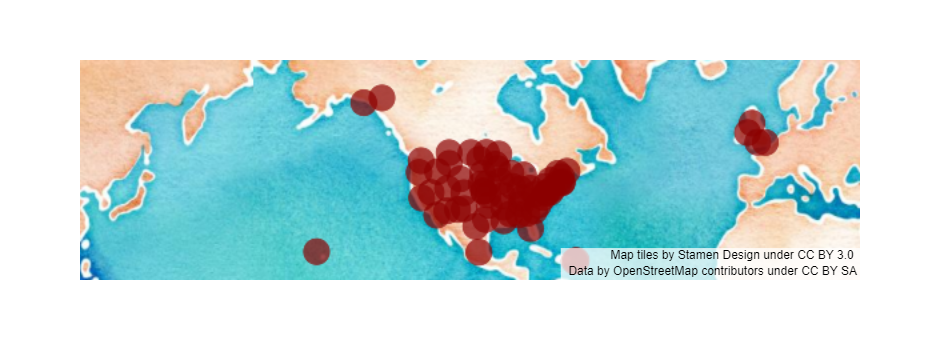

In [23]:
px.scatter_mapbox(
    lon=state_groups['Longitude'],
    lat=state_groups['Latitude'],
    zoom=1,
    center=go.layout.mapbox.Center(
            lat=44.967243,
            lon=-103.77155
        ),
    size=[1] * state_groups.shape[0],
    color_discrete_sequence=['darkred'],
    mapbox_style='stamen-watercolor'
 )

In [8]:
app.layout = html.Div([dcc.Dropdown(id='map_dropdown_menu', 
                value='BusinessName',
                options=[{'label':col, 'value':col} for col in country_counts.iloc[:, 2:]]
)
                ,dcc.Graph(id='map1')
                      ])
@app.callback(Output('map1', 'figure'),
 Input('map_dropdown_menu', 'value'))
def state_map1(col: str):

    fig= px.choropleth(data_frame=country_counts, locationmode='USA-states', locations='state_abrv' , 
                    color=col, color_continuous_scale='amp', animation_frame='CloseDate', height=700, width=1000,
                    hover_name='state_abrv')
    fig.layout.title = col
    fig.layout.geo.showframe = False
    fig.layout.geo.showsubunits = True
    fig.layout.geo.showcountries = True
    fig.layout.geo.projection.type = 'natural earth'
    fig.layout.geo.lonaxis.range = [-300,300]
    fig.layout.geo.lataxis.range = [-53, 76]
    return fig
app.run_server(mode='inline')